# Factorization Machines 

Factorization machines (FM) is a supervised algorithm that can be used for classification, regression, and ranking tasks. Particularly, it is a generalization of the linear regression model and the matrix factorization model. 

FM is formulated as a linear model, with interactions between features as additional parameters (features). However, these user/item indicators can be augmented with arbitrary auxiliary features, for example, user or item attributes and/or contextual features relevant to the interaction itself. These feature interactions are done in their latent space representation instead of their plain format.

![](https://drive.google.com/uc?id=1-1ywT0sOGrYs8lXJ-zljSrF2mF6gQxvS)

* A linear model, given a vector *x* models its output *y* as: 

  ![](https://drive.google.com/uc?id=1U1HUGuROvvxHQ-abyJHx5HgoQvd7ExDD)
  
  where *w* are the learnable weights of the model.

  The drawback of this model is that it does not handle feature interactions. To capture interactions, we could introduce a weight *Wui* for each feature combination (that combines both user *u* and movie (item) *i* interaction).

*  The resulting model for a factorization machine of degree two is defined as:
![](https://drive.google.com/uc?id=1W_ndd8TORVF_3zFk40wNifBPZYtPP0jo)

   Compared to our previous model, this formulation has the advantages that it can capture feature interactions at least for two features at a time. However, this introduces a large number of *w2* variables.

* To solve this complexity issue, Factorization Machines takes inspiration from matrix factorization, and models the feature interaction using latent factors.Therefore previous equiation can be  re-formulation as low-rank re-formulation to reduce the number of additional parameters for the factorization machine.

  ![](https://drive.google.com/uc?id=1L9cx5gghNPaf_FpTCWj6EwhS6--FhAMg)

  The first two terms correspond to the linear regression model and the last term is an extension of the matrix factorization model. If the feature *i*  represents an item and the feature *j*  represents a user, the third term is exactly the dot product between user and item embeddings. 

-------------------------------
**Advantages:** We'll now wrap up the theoretical section of factorization machine, with some of its advantages:

* We can observe from the model equation that it can be computed in linear time.
* By leveraging ideas from matrix factorization, we can estimate higher order interaction effects even under very sparse data.
* Compared to traditional matrix factorization methods, which is restricted to modeling a user-item matrix, we can leverage other user or item specific features making factorization machine more flexible.

# Model implementation in PyTorch

In [1]:
# import libraries
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch.autograd import Variable
torch.manual_seed(2020)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Initialize a Loader class
class Loader():
    # Set the iterator
    current = 0

    def __init__(self, x, y, batchsize=1024, do_shuffle=True):
        """
        :param x: features
        :param y: target
        :param batchsize: batch size = 1024
        :param do_shuffle: shuffle mode turned on
        """
        self.shuffle = shuffle
        self.x = x
        self.y = y
        self.batchsize = batchsize
        self.batches = range(0, len(self.y), batchsize)
        if do_shuffle:
            # Every epoch re-shuffle the dataset
            self.x, self.y = shuffle(self.x, self.y)

    def __iter__(self):
        # Reset & return a new iterator
        self.x, self.y = shuffle(self.x, self.y, random_state=0)
        self.current = 0
        return self

    def __len__(self):
        # Return the number of batches
        return int(len(self.x) / self.batchsize)

    def __next__(self):
        # Update iterator and stop iteration until the batch size is out of range
        n = self.batchsize
        if self.current + n >= len(self.y):
            raise StopIteration
        i = self.current

        # Transform NumPy arrays to PyTorch tensors
        xs = torch.from_numpy(self.x[i:i + n])
        ys = torch.from_numpy(self.y[i:i + n])
        self.current += n
        return xs, ys
    
def index_into(arr, idx):
    # 2D array indexing
    new_shape = (idx.size()[0], idx.size()[1], arr.size()[1])
    return arr[idx.resize(torch.numel(idx.data))].view(new_shape)

We can reorganize the third term of FM which could greatly reduce the computation cost, leading to a linear time complexity. The reformulation of the pairwise interaction term is as follows:

  ![](https://drive.google.com/uc?id=1_MElToR5G_6bDhv4S3nrZKS8KmT9Zc1c)


In [3]:
def factorization_machine(v, x=None):
    """
    Takes an input 2D matrix v of n vectors, each d-dimensional
    :param v: (batchsize, n_features, dim)
    :param x: (batchsize, n_features) functions as a weight array, assumed to be 1 if missing
    :return: output that is d-dimensional
    """
    batchsize = v.size()[0]
    n_features = v.size()[1]
    n_dim = v.size()[2]

    if x is None:
        x = Variable(torch.ones(v.size()))
    else:
        x = x.expand(batchsize, n_features, n_dim)

    # Uses Rendle's trick for computing pairs of features in linear time
    square_of_sum  = (v * x).sum(dim=1) ** 2.0
    sum_of_square  = (v ** 2.0 * x ** 2.0).sum(dim=1)
    return 0.5 * (square_of_sum  - sum_of_square )

In [4]:
class FM(nn.Module):
    """
    Factorization Machines model class
    """
    # Iteration counter
    itr = 0

    def __init__(self, n_feat, k=10, c_feat=1.0, c_bias=1.0):
        """
        :param n_feat: Feature column
        :param k: Dimensions constant
        :param c_feat: Regularization constant for the features
        :param c_bias: Regularization constant for the biases
        """
        super(FM, self).__init__()

        # These are the hyper-parameters
        self.k = k
        self.n_feat = n_feat
        self.c_feat = c_feat
        self.c_bias = c_bias

        # The embedding matrices for the features and the feature's biases
        self.feat = nn.Embedding(n_feat, k)
        self.bias_feat = nn.Embedding(n_feat, 1)

    def __call__(self, train_x):
        """This is the most important function in this script"""
        # Pull out biases
        biases = index_into(self.bias_feat.weight, train_x).squeeze().sum(dim=1)

        # Initialize vector features using the feature weights
        vector_features = index_into(self.feat.weight, train_x)

        # Use factorization machines to pull out the interactions
        interactions = factorization_machine(vector_features).squeeze().sum(dim=1)

        # Final prediction is the sum of biases and interactions
        prediction = biases + interactions
        return prediction

    def loss(self, prediction, target):
        """
        Function to calculate the loss metric
        """
        # Calculate the Mean Squared Error between target and prediction
        loss_mse = F.mse_loss(prediction.squeeze(), target.squeeze())

        # Compute L2 regularization over feature matrices
        prior_feat = l2_regularize(self.feat.weight) * self.c_feat

        # Add the MSE loss and feature regularization to get total loss
        total = (loss_mse + prior_feat)
        
        return total

# FMs are prone to overfitting and for this reason L2 regularization is applied
def l2_regularize(array):
    """
    Function to do L2 regularization
    """
    loss = torch.sum(array ** 2.0)
    return loss

In [5]:
# get the data
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

--2021-08-31 09:26:13--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  29.6MB/s    in 0.2s    

2021-08-31 09:26:14 (29.6 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [6]:
# read the data
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', engine='python', names=('userId', 'movieId','ratings','timestamp'))

# Create users dataframe
users = pd.read_csv("./ml-1m/users.dat", sep='::', engine='python', names=['userId', 'gender', 'age', 'occupation', 'zipcode'])

# Create users dataframe
movies = pd.read_csv("./ml-1m/movies.dat", sep='::', engine='python', names=['movieId', 'title', 'genres_str'])

# Is this rating the first rating ever for that user, or the nth?
ratings['rank'] = ratings.groupby("userId")["timestamp"].rank(ascending=True).astype('int64')

# Merge ratings & user features
dataset = ratings.merge(users, on='userId')
dataset = dataset.merge(movies, on='movieId')
dataset = dataset.sample(frac=1)
dataset.drop(columns=['timestamp', 'zipcode', 'title', 'genres_str'], inplace=True)
dataset['gender'] = dataset['gender'].map({'M':0, 'F':1})
assert len(ratings) == len(dataset)

# Compute cardinalities
n_user = dataset.userId.max() + 1
n_item = dataset.movieId.max() + 1
n_rank = dataset['rank'].max() + 1
n_age = dataset['age'].max() + 1
n_occu = dataset['occupation'].max() + 1
n_gen = dataset['gender'].nunique()
# n_feat = n_user + n_item + n_rank + n_age + n_occu + n_gen
n_feat = n_user + n_item + n_occu + n_rank

print('n_user', n_user)
print('n_item', n_item)
print('n_rank', n_rank)
print('n_gen', n_gen)
print('n_age', n_age)
print('n_occu', n_occu)
print('n_feat', n_feat)
print('n_rows', len(dataset))

display(dataset.head())

n_user 6041
n_item 3953
n_rank 2315
n_gen 2
n_age 57
n_occu 21
n_feat 12330
n_rows 1000209


,userId,movieId,ratings,rank,gender,age,occupation
51418,564,1207,5,15,0,45,1
252092,5848,50,3,324,0,50,20
786551,1978,609,3,3,0,1,10
487045,5287,3703,4,36,0,25,8
670138,5048,3635,3,10,1,35,7


In [7]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# split the dataset into training and testing datasets
train_df, test_df = train_test_split(dataset, test_size=0.1, random_state=42, stratify=dataset.ratings)

train_df.loc[:, 'movieId'] = train_df.loc[:, 'movieId'] + n_user - 1
train_df.loc[:, 'rank'] = train_df.loc[:, 'rank'] + n_user + n_item - 2
train_df.loc[:, 'occupation'] = train_df.loc[:, 'occupation'] + n_user + n_item + n_rank - 3

test_df.loc[:, 'movieId'] = test_df.loc[:, 'movieId'] + n_user - 1
test_df.loc[:, 'rank'] = test_df.loc[:, 'rank'] + n_user + n_item - 2
test_df.loc[:, 'occupation'] = test_df.loc[:, 'occupation'] + n_user + n_item + n_rank - 3

train_X = torch.tensor(train_df[['userId', 'movieId', 'rank', 'occupation']].values)
train_y = torch.FloatTensor(train_df['ratings'].values)
test_x = torch.tensor(test_df[['userId', 'movieId', 'rank', 'occupation']].values)
test_y = torch.FloatTensor(test_df['ratings'].values)

train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=1024)
test_loader = DataLoader(TensorDataset(test_x, test_y), batch_size=1024)

In [8]:
# fit the model to the input data and label.
def fit(model, dataloader, optimizer):
    model.train()
    # for epoch in range(epochs):
    for batch in dataloader:
        optimizer.zero_grad()
        x, y = batch[0], batch[1]
        y_pred = model(x)
        loss = model.loss(y_pred, y)
        loss.backward()
        optimizer.step()
    return loss.item()

# evaluate the model on unseen data
def evaluate(model, dataloader):
    model.eval()
    for batch in dataloader:
        with torch.no_grad():
            x, y = batch[0], batch[1]
            y_pred = model(x)
            loss = model.loss(y_pred, y)
    return loss.item()

In [9]:
# Define the Hyper-parameters
lr = 1e-2  # Learning rate
k = 10  # Number of dimensions per user and item
c_bias = 1e-5  # Bias constant
c_feat = 1e-5  # Regularization constant
epochs = 10

# Instantiate the model class object
model = FM(n_feat, k=k, c_bias=c_bias, c_feat=c_feat)

# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Loop through pre-defined number of epochs
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Perform training on the train set
    train_loss = fit(model, dataloader=train_loader, optimizer=optimizer)
    print('epoch:', epoch, 'training loss:', train_loss)
    train_losses.append(train_loss)

    # Perform evaluation on the test set
    test_loss = evaluate(model, test_loader)
    print('epoch:', epoch, 'testing  loss:', test_loss)
    test_losses.append(test_loss)

# Save the model checkpoint
torch.save(model.state_dict(), 'mf.pt')

epoch: 0 training loss: 2.4446353912353516
epoch: 0 testing  loss: 2.3055500984191895
epoch: 1 training loss: 0.9909727573394775
epoch: 1 testing  loss: 1.2814478874206543
epoch: 2 training loss: 0.8524733781814575
epoch: 2 testing  loss: 1.0710121393203735
epoch: 3 training loss: 0.7751405239105225
epoch: 3 testing  loss: 0.9822860360145569
epoch: 4 training loss: 0.7207872867584229
epoch: 4 testing  loss: 0.9182935357093811
epoch: 5 training loss: 0.7187595963478088
epoch: 5 testing  loss: 0.8716986179351807
epoch: 6 training loss: 0.6828450560569763
epoch: 6 testing  loss: 0.8555312752723694
epoch: 7 training loss: 0.6469877362251282
epoch: 7 testing  loss: 0.8636407256126404
epoch: 8 training loss: 0.6267709136009216
epoch: 8 testing  loss: 0.8690025806427002
epoch: 9 training loss: 0.6135601997375488
epoch: 9 testing  loss: 0.8690454959869385


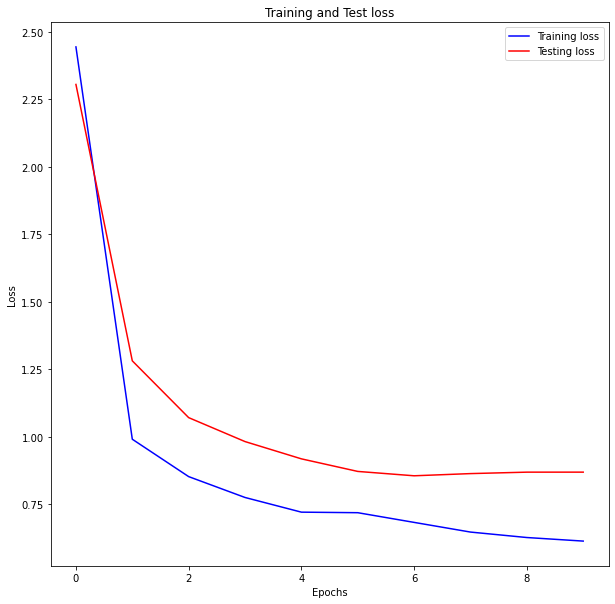

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.plot( train_losses, 'b', label='Training loss')
plt.plot( test_losses, 'r', label='Testing loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Undertanding Model Outputs

In [11]:
# explore the features embedding matrix weights
feat_weight = model.feat.weight
print(feat_weight.size())
print(feat_weight[0])

torch.Size([12330, 10])
tensor([ 1.2774e-38, -4.4778e-40, -2.0292e-40, -6.5776e-38, -3.6661e-39,
         3.7298e-39, -1.6310e-39,  8.6407e-40, -1.5546e-39,  1.6225e-39],
       grad_fn=<SelectBackward>)


In [12]:
# explore the biases embedding matrix weights
bias_weight = model.bias_feat.weight
print(bias_weight.size())
print(bias_weight[0])

torch.Size([12330, 1])
tensor([-0.7479], grad_fn=<SelectBackward>)


In [13]:
# one batch of train loader looks like
next(iter(train_loader))

[tensor([[ 3191,  6627, 10244, 12318],
         [ 4973,  9113, 10108, 12308],
         [ 1950,  7431, 10030, 12318],
         ...,
         [ 3345,  9403, 10021, 12313],
         [ 3526,  7993, 10588, 12308],
         [ 5306,  8129, 10223, 12323]]),
 tensor([5., 3., 4.,  ..., 4., 4., 4.])]

In [14]:
# get vector features using the index from 2-dimensonal (number of features, k-factor) feature weights matrix
vector_features = index_into(feat_weight, train_X)
print(len(vector_features))
print(vector_features[0])
print(vector_features.size())

900188
tensor([[-0.0388,  0.1005,  0.0890,  0.0713,  0.1999, -0.0274,  0.4738,  0.0937,
          0.3804, -0.3489],
        [ 0.3164,  0.9788,  0.1159, -0.1089, -0.1467,  0.1934, -0.1138,  0.3784,
         -0.0131, -0.7459],
        [ 0.1862,  0.0786,  0.1279, -0.0417,  0.2084, -0.0909,  0.0780, -0.0385,
         -0.0795,  0.0134],
        [-0.0483,  0.0544,  0.0186,  0.0017, -0.0850,  0.0189,  0.0341, -0.0486,
         -0.0106,  0.0574]], grad_fn=<SelectBackward>)
torch.Size([900188, 4, 10])


In [15]:
# compute interactions using usign Rendle's trick 
interactions = factorization_machine(vector_features).squeeze().sum(dim=1)
print(len(interactions))
print(interactions)

900188
tensor([ 0.3719,  0.0140, -0.1061,  ...,  0.1586,  0.5374,  0.8604],
       grad_fn=<SumBackward1>)


In [16]:
# get baiases from bias weights matrix
biases = index_into(bias_weight, train_X).squeeze().sum(dim=1)
print(len(biases))
print(biases)

900188
tensor([3.4634, 2.9233, 3.0283,  ..., 3.7219, 4.1200, 3.6828],
       grad_fn=<SumBackward1>)


In [17]:
# compute final predictions by summing bias and interaction
prediction = biases + interactions
print(prediction.detach()[:10])
print(train_y[:10])

tensor([3.8353, 2.9372, 2.9222, 3.6963, 3.6009, 3.6175, 2.9777, 2.6884, 4.2625,
        3.1748])
tensor([5., 3., 4., 4., 4., 4., 4., 3., 4., 3.])


We can see that the model reconstructs original ratings nor that well. Things we can try to improve that:

* Get more data
* Tune hyper-patameters (especially k-factor)
* Train the model for more epochs

# Make predictions

In [18]:
dataset[dataset.userId == 5533]

,userId,movieId,ratings,rank,gender,age,occupation
535785,5533,2453,2,12,1,50,2
630697,5533,247,4,12,1,50,2
491029,5533,858,4,8,1,50,2
372121,5533,2442,4,2,1,50,2
353658,5533,1221,4,8,1,50,2
894409,5533,1913,5,2,1,50,2
49466,5533,260,5,12,1,50,2
679053,5533,2019,5,18,1,50,2
516854,5533,969,5,18,1,50,2
340043,5533,266,4,5,1,50,2


In [19]:
import numpy as np

def make_predictions(user, n=10):
  """
  Funtion to make top N recommendations to a given user
  """
  # users's watched movies
  watched_movies = dataset[dataset.userId == user]['movieId'].values

  # construct samples matrix
  samples = []
  for movie in movie_ids:
    sample = [user, movie, rank, occupation]
    samples.append(sample)
  samples = torch.tensor(samples)

  # run the model for our samples
  predictions = model(samples).detach().numpy()

  normalized_predictions = [i/max(predictions)*5 for i in predictions]
  normalized_predictions = {key:value for (key,value) in enumerate(normalized_predictions)}

  # filter out movies the user haven't watched
  unwatched_movies = {}
  for i, movie in enumerate(movie_ids):
    if movie not in watched_movies:
      unwatched_movies[i] = movie
 
  # get the indexes of top n ratings from sorted predictions
  indexes = [idx for idx in sorted(normalized_predictions, key=normalized_predictions.get, reverse=True)][:n]
  
  # get the original movie indexes
  recommendations = []
  for idx in indexes:
    recommendations.append(unwatched_movies.get(idx))

  return recommendations

user = 5533 # take userId == 5533 as an example
rank = 1 + n_user + n_item
occupation = dataset[dataset.userId == user]['occupation'].unique().item() + n_user + n_item + n_rank

n = 10 # make 10 recommendations
movie_ids = dataset['movieId'].unique()
# run the function
movies = make_predictions(user, n=10)

# print out the recommended movies
print(f'Top {n} recommended movie ids:')
for idx in movies:
  print(idx)

Top 10 recommended movie ids:
3902
597
1171
2852
3801
1940
567
1132
195
2867
